In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as 

## Data driven orthogonal basis selection for functional data analysis

* In practise, basis fucntions for data representation are chosen for their mathematical conveniece: Fourier basis are used to describe periodic data and spline bases are used for functional information without any strongly cyclic variation [From functional data to smooth functions - J. Ramsay and B. Silverman]<br>

* Alternatively, large (high-dimensional) basis are used to assure that the representation is sufficientily accurate<br>

* In both cases there exist inefficiencies leading to unncecessarily complex problems

Paper proposes an algorithmic search for efficient knot patterns and uses them for representation of sparse data, incorporating machine learning algorithms for the choice of basis reducing the mean square error uniformly for all samples

Method efficiently learns from the data knot placements, before constructing an orthonormal spline basis, termed splinets as an efficient orthogonalisation of the B-splines

## Splines

* Splines divide the distribution of the data into separate portions and fit linear or low degree polynomial functions on each of these portions. 
* The points where the division occurs are called knots
* Functions that we can use for modelling each portion are knwon as piecewise functions

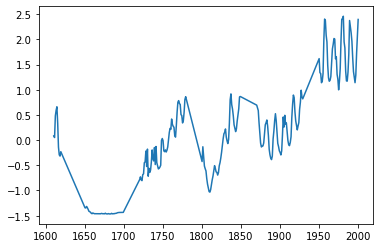

In [49]:
data = np.genfromtxt('/home/jake/Documents/GPBasisFunctions/Data_driven_orthogonal_basis_selection/data/solar.txt', delimiter=',')
X = data[:, 0:1]
Y = data[:, 2:3]
Y = (Y - Y.mean()) / Y.std()

# remove some chunks of data
X_test, Y_test = [], []

intervals = ((1620, 1650), (1700, 1720), (1780, 1800), (1850, 1870), (1930, 1950))
for low, up in intervals:
    ind = np.logical_and(X.flatten() > low, X.flatten() < up)
    X_test.append(X[ind])
    Y_test.append(Y[ind])
    X = np.delete(X, np.where(ind)[0], axis=0)
    Y = np.delete(Y, np.where(ind)[0], axis=0)
X_test, Y_test = np.vstack(X_test), np.vstack(Y_test)

X_train = pd.DataFrame(X.flatten())
Y_train = pd.DataFrame(Y.flatten())
X_test = pd.DataFrame(X_test)
Y_test = pd.DataFrame(Y_test)

plt.plot(X_train[0], Y_train[0])

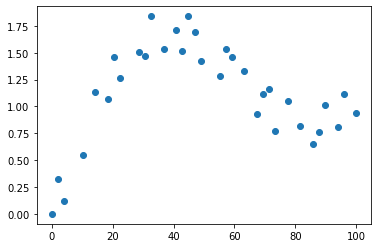

In [93]:
from sklearn.model_selection import train_test_split

X = np.linspace(0,100,50)
Y = np.sin(0.05*X) + 0.02*X + 0.2*np.sin(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

plt.scatter(X_train,Y_train)

## Polynomial Regression

In [174]:
class polynomial_regression:

    def __init__(self, X, Y, order):

        # Data
        self.X = X
        self.Y = Y
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X, self.Y, test_size=0.8)

        # Parameters
        self.order = order
        self.theta = None

        # Prediction
        self.Y_predict = None
        self._MSE = None

    def feature_matrix(self, X):
        PHI = []
        for x in X:
            phi = []
            for i in range(self.order+1):
                phi.append(x**i)
            PHI.append(phi)
        PHI = np.array(PHI).reshape([X.shape[0],self.order+1])
        return PHI

    def MLE(self):
        PHI = self.feature_matrix(self.X_train)
        theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(PHI),PHI)),np.transpose(PHI)),self.Y_train)
        self.theta = np.array(theta).reshape([self.order+1, 1])
        return 

    def predict(self, X):
        PHI_test = self.feature_matrix(X)
        Y_predict = np.matmul(PHI_test, self.theta)
        return Y_predict

    def plot(self):
        fig = plt.figure(figsize=(9,6))
        plt.scatter(self.X_train, self.Y_train, color='black')
        #plt.scatter(self.X_test, self.Y_test, color='red')
        y_theta = self.predict(X)
        plt.plot(X, y_theta)

    def MSE(self):
        self.Y_predict = self.predict(self.X_test)
        self._MSE = np.mean((self.Y_test - self.Y_predict)**2)
        print('MSE = ', self._MSE)

    def inference(self):
        self.MLE()
        self.MSE()
        self.plot()


MSE =  0.41708630686344456


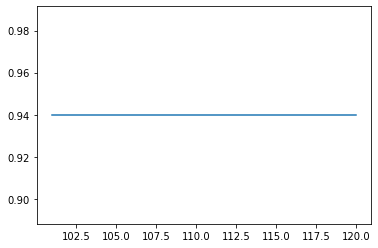

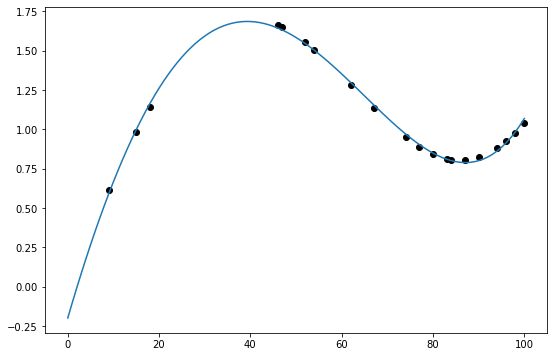

In [203]:
X1 = np.linspace(0,100,101)
X2 = np.linspace(101,120,20)
X3

Y1 = np.sin(0.05*X) + 0.02*X + 0.2*np.sin(X)
Y2 = np.repeat(Y1[-1], 20) 
Y3 = Y1[-1] + np.sin(0.03*X3)

plt.plot(X2, Y2)

PR = polynomial_regression(X, Y, 4)
PR.inference()


In [ ]:
class B_spline_regression:

    def __init__(self, X, Y, num_knots, order):

        # Data
        self.X = X
        self.Y = Y
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X, self.Y, test_size=0.4)

        # Parameters
        self.num_knots = num_knots
        self.order = order
        self.theta = None
        self.DOF = (self.num_knots + 1)*(self.order + 1) - (self.num_knots)*3

        # Knots
        self.knots = self.__knots(X)

        # Prediction
        self.Y_predict = None
        self._MSE = None

        self.__testing()

    ### Internal Functions ###

    def __knots(self, X):
        spacing = (max(X)-min(X)) / (self.num_knots - 1)
        knots = np.linspace(min(X)-(self.order*spacing), max(X)+(self.order*spacing), self.num_knots + (2*self.order))
        return knots

    def __basis0(self, xi):
        return np.where(np.all([self.knots[:-1] <=  xi, xi < self.knots[1:]],axis=0), 1.0, 0.0)

    def __basis(self, xi, p):
        """Recursive Cox - de Boor function (for internal use).
        Compute basis functions and optionally their first derivatives.
        """

        if p == 0:
            return self.__basis0(xi)
        else:
            basis_p_minus_1 = self.__basis(xi, p - 1)

        first_term_numerator = xi - self.knots[:-p]
        first_term_denominator = self.knots[p:] - self.knots[:-p]

        second_term_numerator = self.knots[(p + 1):] - xi
        second_term_denominator = (self.knots[(p + 1):] -
                                   self.knots[1:-p])


        #Change numerator in last recursion if derivatives are desired
        if compute_derivatives and p == self.p:

            first_term_numerator = p
            second_term_numerator = -p

        #Disable divide by zero error because we check for it
        with np.errstate(divide='ignore', invalid='ignore'):
            first_term = np.where(first_term_denominator != 0.0,
                                  (first_term_numerator /
                                   first_term_denominator), 0.0)
            second_term = np.where(second_term_denominator != 0.0,
                                   (second_term_numerator /
                                    second_term_denominator), 0.0)

        return  (first_term[:-1] * basis_p_minus_1[:-1] +
                 second_term * basis_p_minus_1[1:])



    def __testing(self):
        for xi in np.random.choice(self.X_train, 5):
            print(self.__basis(xi, 3))

        print(self.knots)
        print(self.knots[])
        return

    

    ## Inference functions

    def design_matrix(self, X):
        B = []
        for x in X:
            b = self.piecewise_polynomial(x)
            B.append(b)
        B = np.array(B).reshape([X.shape[0], self.DOF])
        return B